This main goals of the notebook is to develop a data pipeline which is able to ingest data from a weblink. The data is then converted into data structures. The python's pandas library is used to for this purpose. There are several other option to achieve this (Like Pyspark). The pandas is used to perform the necessary transformations (when we try to understand the data, then it will be clear which necessary transformations are required). The data is then loaded into a sqlite database. To achieve this, an sql script that creates the necessary tables is run from within the notebook. The pandas dataframes are then imported into these sqlite database tables.
Let's begin!!

In [1]:
# the cells contains all the imported python libraries necessary to execute this notebook
import zipfile
import wget
import pandas as pd
import sqlite3
from sqlite3 import OperationalError
from IPython import display
import os

# 01. Extract the data

In [2]:
# download zip file, the files will be downloaded in your current working directory
url='https://files.grouplens.org/datasets/movielens/ml-20m.zip'
wget.download(url)

'ml-20m.zip'

In [3]:
#unzip, which will create the folder ml-20m in your working directory
with zipfile.ZipFile("ml-20m.zip","r") as zip_ref:
    zip_ref.extractall()

This actually completes the extraction process, as data is now available on local HD. In next step, just open the extracted folder and try to visualize the file (for example, notepad++) and get a feel for the data.
In total, there are 6 comma separated files along with a readme text file. Go through ReadMe file. Each csv file and its contents are properly explained.

## Data structure and Data Understanding

The csv files are loaded into the pandas dataframe. The dataframes in pandas are 2D data structures much similar to that of the tables.
Each six files are loaded one by one. At the same time, an initial glance of the data can help to understand and identify the transformation needed, before the data is loaded into a database.

In [4]:
df_movies = pd.read_csv("ml-20m/movies.csv" ,sep=',', header='infer')
df_genome_scores = pd.read_csv("ml-20m/genome-scores.csv" ,sep=',', header='infer')
df_genome_tags = pd.read_csv("ml-20m/genome-tags.csv" ,sep=',', header='infer')
df_tags = pd.read_csv("ml-20m/tags.csv" ,sep=',', header='infer')
df_ratings = pd.read_csv("ml-20m/ratings.csv" ,sep=',', header='infer')
df_links = pd.read_csv("ml-20m/links.csv" ,sep=',', header='infer')

In [5]:
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In moviese.csv, the title contains the title as well as the relase year of the movie. Different genres are grouped together and pipe separator is used. It will be helpful to transform these columns for later queries.

In [6]:
df_genome_scores.head(5)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


genome-scores.csv: looks fine

In [7]:
df_genome_tags.head(5)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


genome-tags.csv: looks fine. One another advantage of analyzing these data strcutre is that it will help to define the appropriate data type, when creating tables for saving them in a database.

In [8]:
df_tags.head(5)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


tag.csv: The timestamp data is not in proper format and should be parsed

In [9]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


ratings.csv: Similar to tags, the timestamp data needs to be parsed.

In [10]:
df_links.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


**links.csv: Looks fine!**

**So what can be further steps here.
One would be to check the data quality for accuracy, consistency, duplicates, missing number and so on. However, it is assumed, the data is complete and accurate. If we get problems further down the road, then we can adress the issues as they occur.(however, it is recommended)**

# 02. Transformations

we move to the second step of transformation before loading the data into a database.
 Convetionally, the transformation of the data is made up of certain steps like
 - combining data
 - data cleaning
 - date parsing
 - handle missing and duplicate data
 - engineering feature etc.

 In data understanding section, different necessary transformation were identified that need to be performed. They are as follows:
**movies.csv: Extract year as separate columns.
tags.csv & rating.csv: The timestamp data is not properly formated and need to be parsed.**
(it is assumed that no other transformation other than the above are necessary. If some problem arises later, we will handle it at that time. (this is not recommended, however, for the sake of simplicity and speed, it is assumed that no other transformation are necessary and data quality is fine.

In [11]:
# extract year as a separate column
df_movies['year'] = df_movies['title'].str.extract('.*\((.*)\).*', expand=True)
df_movies.head(5)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


The readme.txt file indicates that the Timestamps in tags.csv and ratings.csv represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970. In next step, we will parse it to datetime.

In [13]:
df_tags['parsed_time'] = pd.to_datetime(df_tags['timestamp'], unit='s')
df_tags.drop(labels=['timestamp'], axis=1, inplace=True)
df_tags.rename(columns={'parsed_time' :'time_tags'},inplace=True)
df_tags.head(20)

,userId,movieId,tag,time_tags
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18
5,65,668,bollywood,2013-05-10 01:37:56
6,65,898,screwball comedy,2013-05-10 01:42:40
7,65,1248,noir thriller,2013-05-10 01:39:43
8,65,1391,mars,2013-05-10 01:40:55
9,65,1617,neo-noir,2013-05-10 01:43:37


Repeating the same procedure with the ratings dataframe

In [14]:
df_ratings['parsed_time'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings.drop(labels=['timestamp'], axis=1, inplace=True)
df_ratings.rename(columns={'parsed_time' :'time_rating'},inplace=True)
df_ratings.head(20)

,userId,movieId,rating,time_rating
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
5,1,112,3.5,2004-09-10 03:09:00
6,1,151,4.0,2004-09-10 03:08:54
7,1,223,4.0,2005-04-02 23:46:13
8,1,253,4.0,2005-04-02 23:35:40
9,1,260,4.0,2005-04-02 23:33:46


# 03. Loading into a database

In this step, we will use python to ingest data into a database in sqlite. The sqlite due to single file format is good for working locally. Although it has some drawback like not supporting multiple writes and users. However, for the current problem, (small to medium database), it shoudl sufffice

In [15]:
#create a database if not existing and establish a connection to it
# Important(database name should be consistent in the cells that come afterwards)
conn = sqlite3.connect('database_20M.db')
print("connected sucessfully")
# The cursor is used to run command against the database
cur = conn.cursor()

connected sucessfully


In [16]:
# a function to execute sql scripts from python
def executeScriptsSQL(filename):
    # Open and read the script file
    fd = open(filename, 'r')
    sqlFile = fd.read()
    fd.close()

    # Differentiate between different command as ; is sued to split them in sqlite
    sqlCommands = sqlFile.split(';')

    # Execute every command from the input file
    for command in sqlCommands:
        # This will skip and report errors
        # For example, if the tables do not yet exist, this will skip over
        # the DROP TABLE commands
        try:
            cur.execute(command)
        except OperationalError as msg:
            print("Command skipped: ", msg)

In [18]:
# executng the script file which creates tables in the data
executeScriptsSQL("script.sql")
print('Table created successfully')

Table created successfully


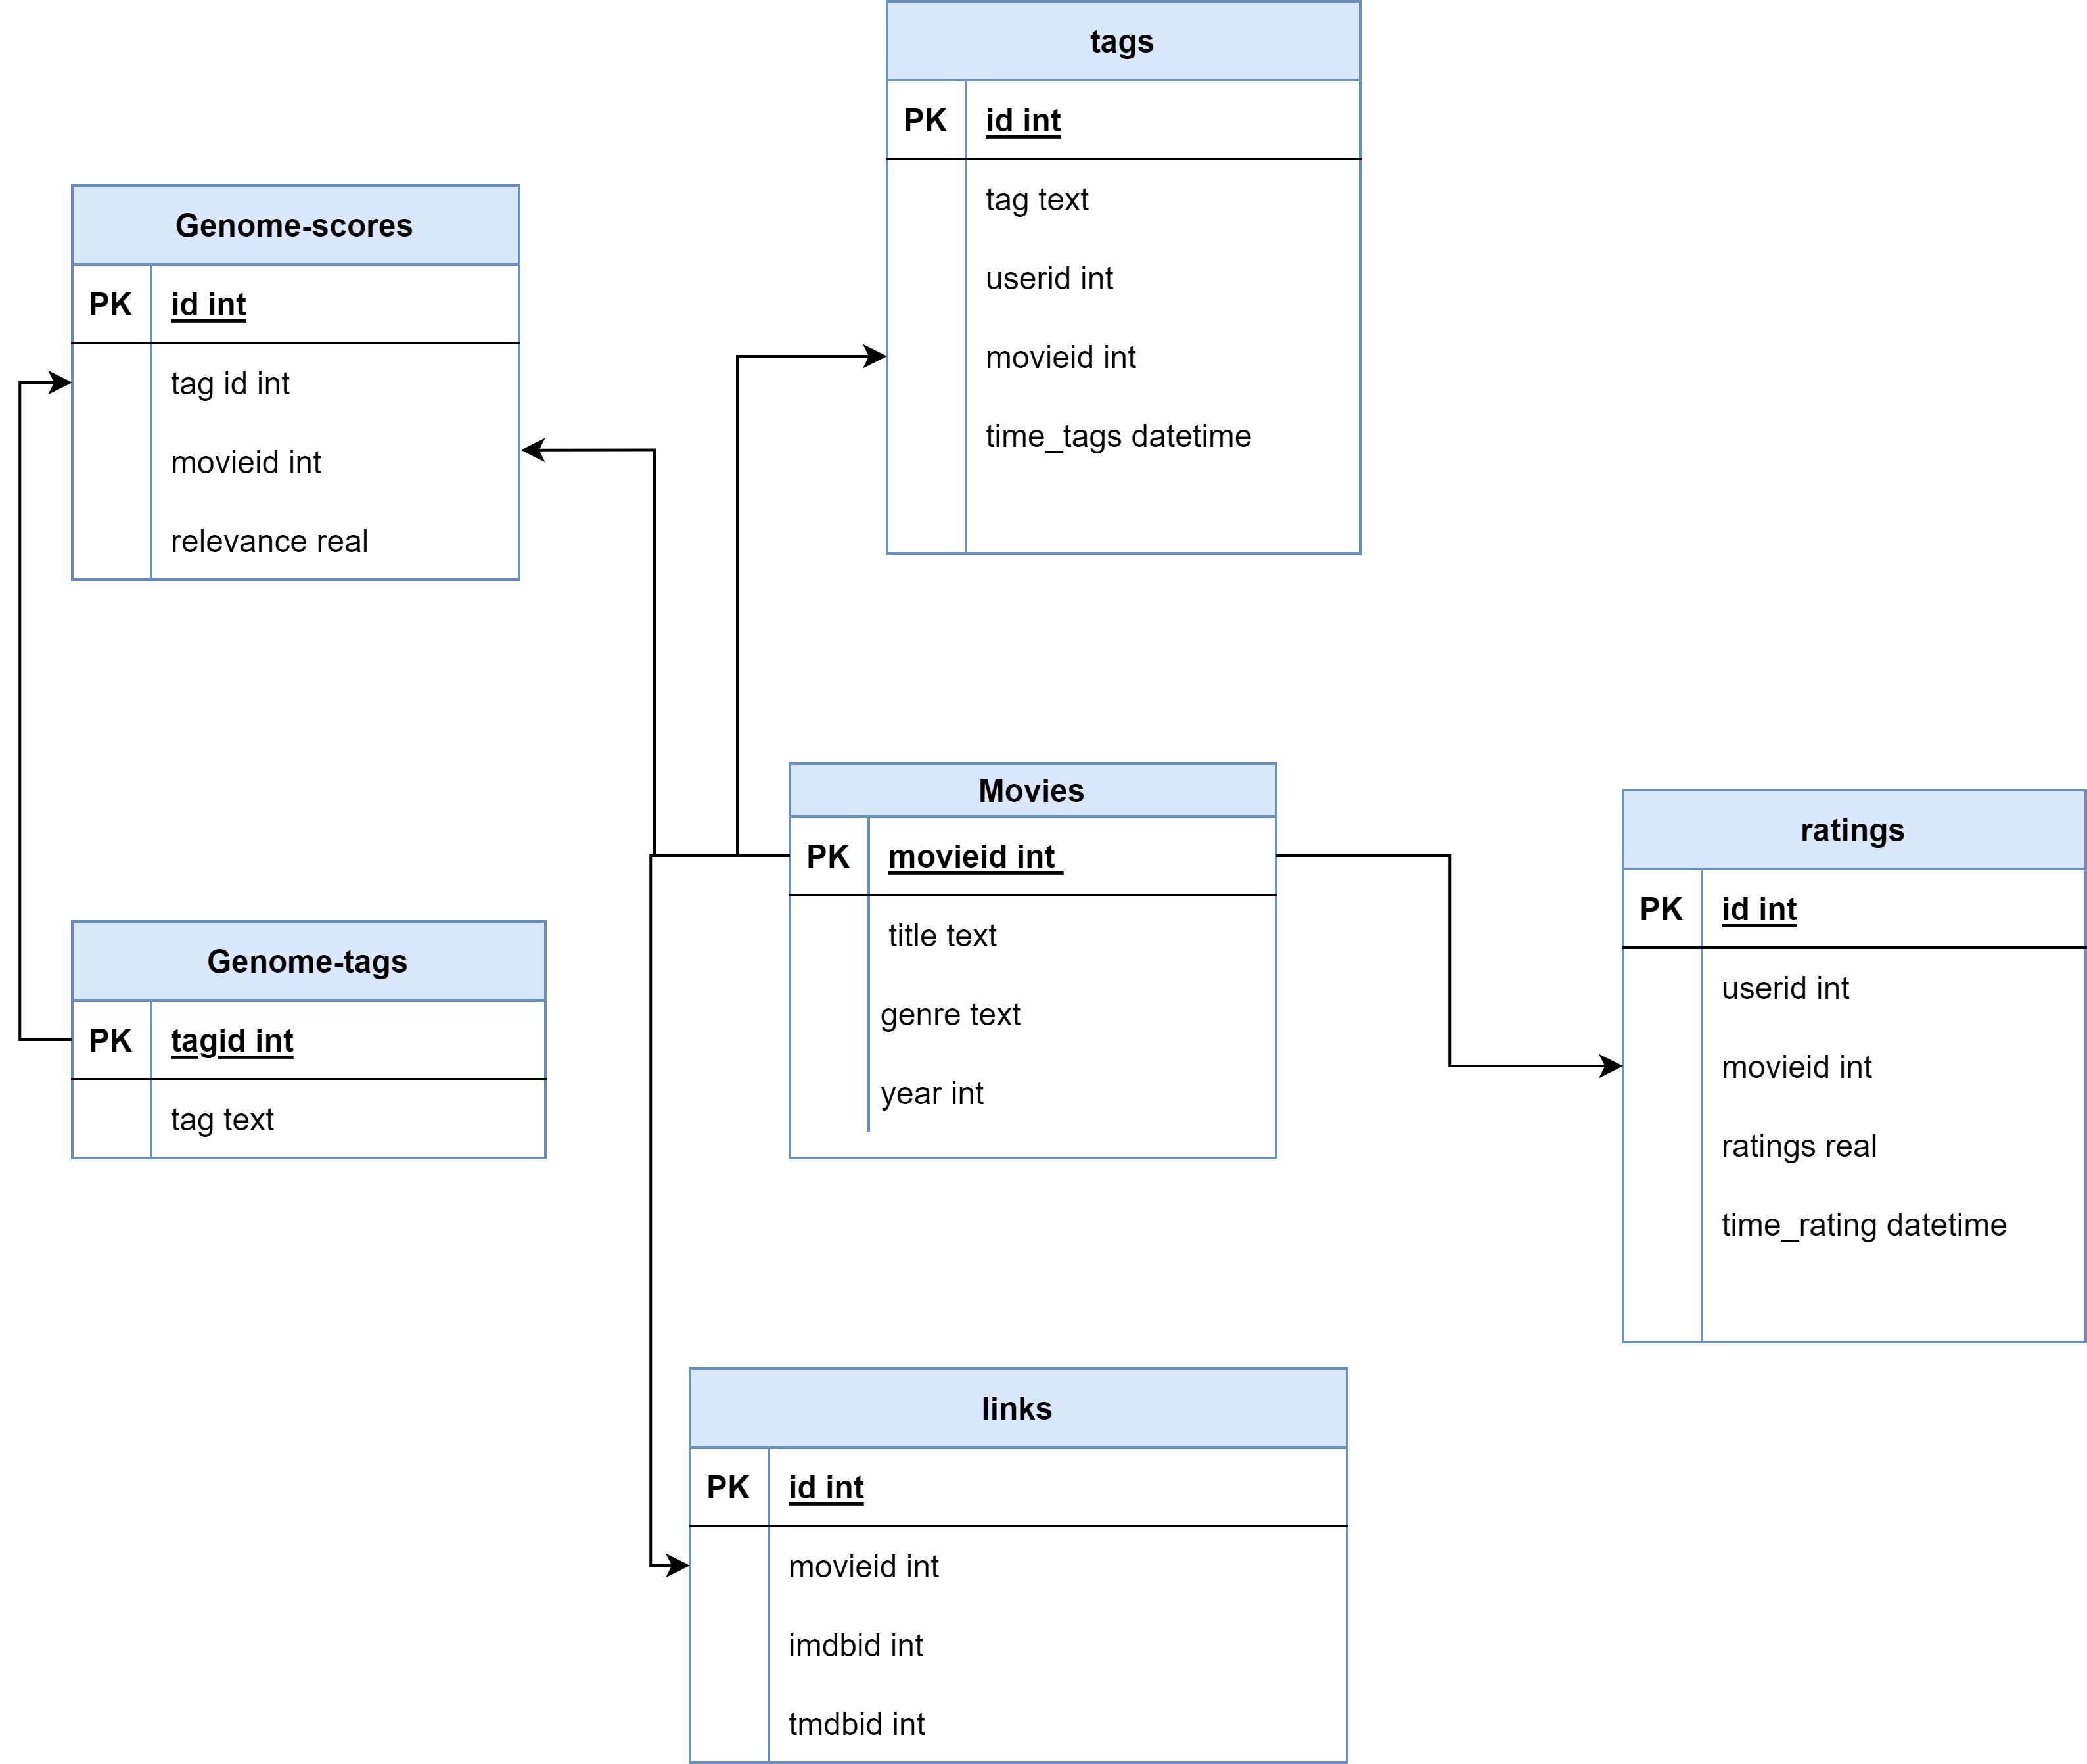

In [19]:
# the script created a database as per following data model
display.Image("./images/ERM.png")

use the pandas to_sql command to transfer the dataframes to the created table in sqlite. Use if_exists='append', in this way, it will append the data to already created tables by script and not overwrite them

In [20]:
df_movies.to_sql('movies', con = conn,if_exists='append', index=False)
df_links.to_sql('links', con = conn,if_exists='append',  index=False)
df_tags.to_sql('tags', con = conn, if_exists='append',index=False)
df_genome_tags.to_sql('genome_tags',if_exists='append', con = conn, index=False)
df_genome_scores.to_sql('genome_scores', if_exists='append',con = conn, index=False)
df_ratings.to_sql('ratings', con = conn,if_exists='append', index=False)
print('data ingested sucessfully')

data ingested sucessfully


In [21]:
# write a simple function to check the data ingestion
def get_db_data(sqlstatement):
    conn = sqlite3.connect('database_20M.db')
    result = pd.read_sql(sqlstatement,conn)
    conn.close()
    return result

In [22]:
get_db_data("SELECT * FROM movies").head(5)

,movieid,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


All records have been sucessfully transferred to the database.

(Note: My IDE is pycharm, which can also be used to connect to this database at the same time. After connecting to database, it is validated that the data is ingetsed and in correct format.)

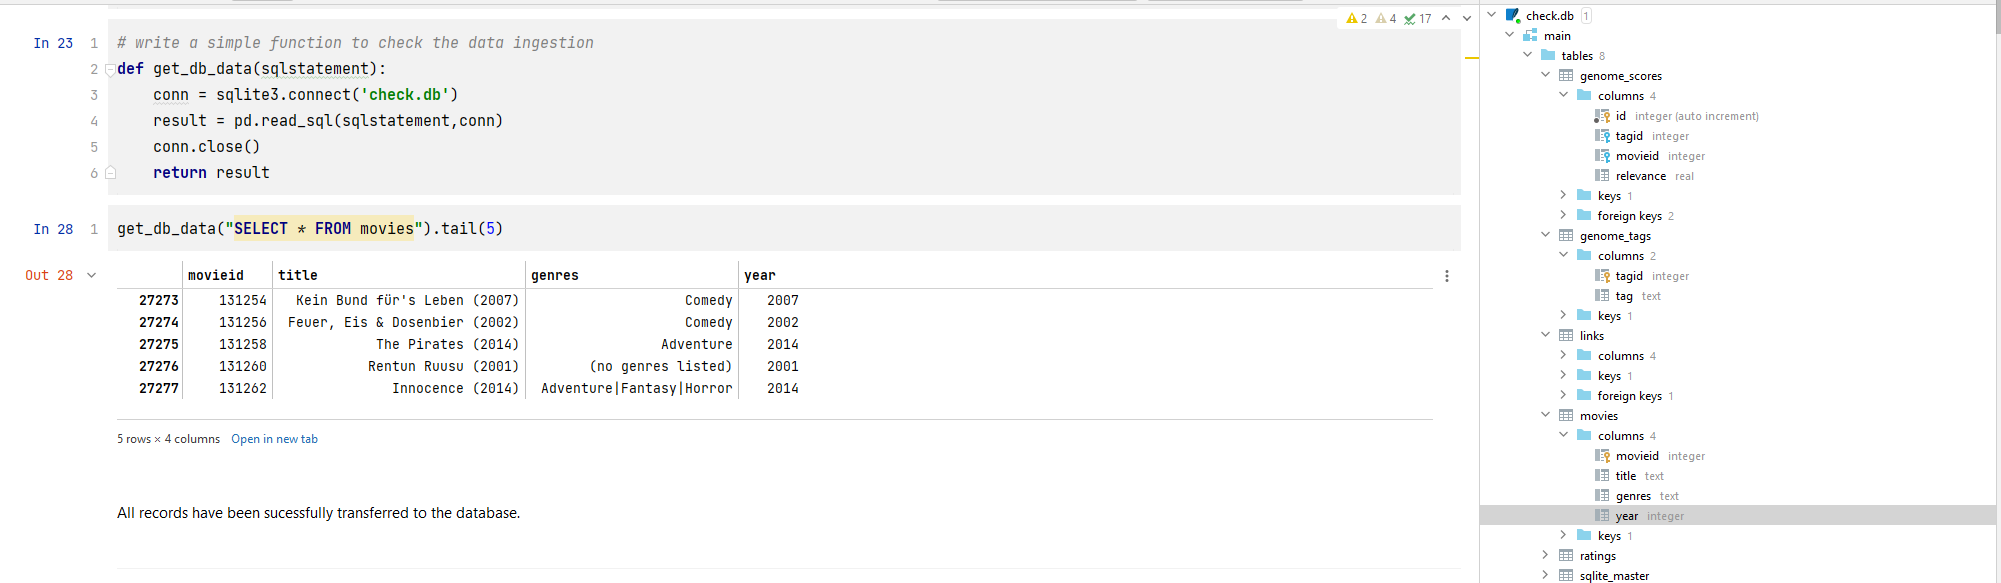

In [23]:
display.Image("./images/status_data.png")

For Task 4, an API service is to be developed that can retrieve movies based on year range, genre and ratings, so we will pre-aggregate a dataframe here as ratings comes from a large number of users for the same movie. So taking an average of ratings agains several user will help.

In [25]:
df_movie_ratings = df_ratings.groupby(['movieId']).mean('rating')
df_movie_ratings.head(5)

,userId,rating
movieId,,
1,69282.396821,3.921240
2,69169.928202,3.211977
3,69072.079388,3.151040
4,69652.913280,2.861393
5,69113.475454,3.064592


In [26]:
df_movie_ratings_combine = pd.merge(df_movies,df_movie_ratings, on='movieId',how='inner')
df_movie_ratings_combine.head(5)

,movieId,title,genres,year,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,69282.396821,3.921240
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,69169.928202,3.211977
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,69072.079388,3.151040
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,69652.913280,2.861393
4,5,Father of the Bride Part II (1995),Comedy,1995,69113.475454,3.064592


In [27]:
df_movie_ratings_combine.drop("userId", axis=1, inplace=True)
df_movie_ratings_combine.head(5)

,movieId,title,genres,year,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.921240
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3.211977
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.151040
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.861393
4,5,Father of the Bride Part II (1995),Comedy,1995,3.064592


The combined dataframe will be transferred to a separate database that will be utilized in the Task 4 to develop the API service

In [29]:
conn = sqlite3.connect('database_MovieRatings.db')
print("connected sucessfully")
# The cursor is used to run command against the database
df_movie_ratings_combine.to_sql('movies', con = conn,if_exists='replace', index=False)
print("Data Transfered")

connected sucessfully
Data Transfered


In [32]:
import os
os.system('jupyter nbconvert --to html Coding_Task_RR_01_02.ipynb')

0